# Kitchen20: an extention to ESC50


The Kitchen20 dataset is a freely available (Creative Commons Attribution-NonCommercial license) collection of short kitchen sounds recordings presented in a unified format (5-second-long clips, 44100 Hz, single channel, compressed @ 192 kbit/s). All clips have been extracted and manually labeled by the author from public field recordings available through bothe the Freesound.org project and diverse participant that agreed on recording specific sounds in their own kitchens.

- Kitchen20: a sound dataset with 800 environmental sounds (20 classes, 40 clips per class)
- ESC70: The concatenation of both ESC50 and Kitchen20

---

The goal of this project is to include specific sounds that would happen in a kitchen to a raw audio dataset of environmental sounds.

This notebook provides a glipse into data.

## Loading the Data:

In [1]:
import os
import shutil
import urllib
import zipfile
import glob
import pandas as pd
import numpy as np
import kitchen20
import kitchen20.kitchen20

dataset = kitchen20.kitchen20.Kitchen20(folds=[1,2,3,4,5],
                                        compute_features=True,
                                        audio_rate=44100)

/media/moreaux-gpu/Data/Dataset/ESC-70/kitchen20/__init__.py


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df  = pd.DataFrame()

for idx in range(len(dataset.labels)):
    
    row = pd.DataFrame([idx], columns=['idx'])
    row['fold'] = dataset.folds_nb[idx]
    row['category'] = dataset.labels[idx]

    # Compute mean and std of the banks in mfcc
    mfcc = dataset.mfcc[idx][:, :]
    mfcc_mean = pd.DataFrame(np.mean(dataset.mfcc[idx][:, :], axis=0)[1:]).T
    mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
    mfcc_std = pd.DataFrame(np.std(dataset.mfcc[idx][:, :], axis=0)[1:]).T
    mfcc_std.columns = list('MFCC_{} std'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
    row = row.join(mfcc_mean)
    row = row.join(mfcc_std)

    # Compute mean and std of zcr
    zcr = dataset.zcr[idx]
    row['ZCR mean'] = np.mean(zcr)
    row['ZCR std'] = np.std(zcr)

    df = df.append(row)

## Confusion matrix code

In [3]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots(figsize=(10,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Bayesian process
find the best set of parameters with a bayesian process method

100%|██████████| 200/200 [00:07<00:00, 28.15it/s, best loss: -0.3525]
best:  {'n_neighbors': 1.2365588549592887}
{'n_neighbors': 1} -- acc:  0.3525


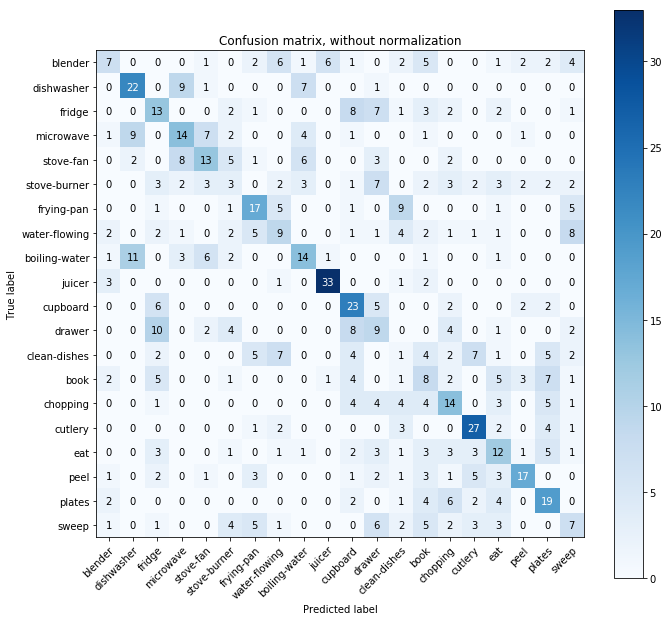

100%|██████████| 200/200 [1:08:17<00:00, 29.44s/it, best loss: -0.49749999999999994]
best:  {'criterion': 1, 'max_depth': 9.878127290526496, 'max_features': 6.104838738734332, 'n_estimators': 725.8371541868648}
{'n_estimators': 725, 'max_depth': 9, 'random_state': 1000, 'criterion': 'entropy', 'max_features': 6} -- acc:  0.49749999999999994


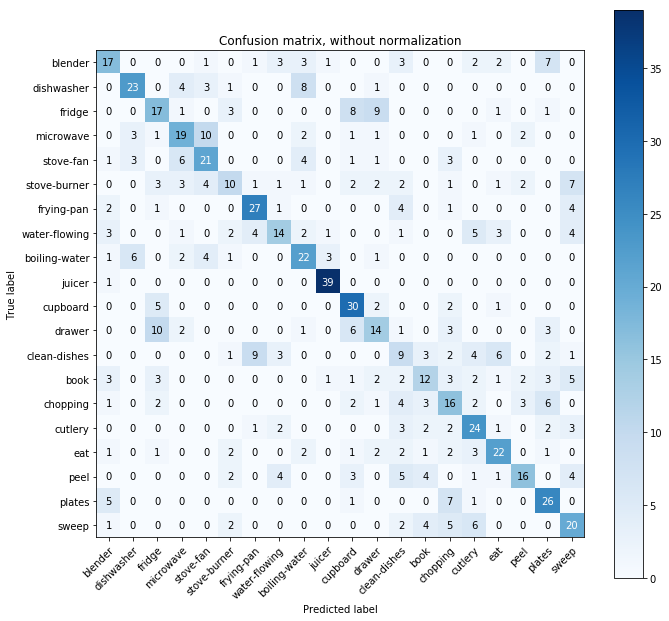

100%|██████████| 200/200 [04:32<00:00,  1.31s/it, best loss: -0.445]             
best:  {'C': 0.022051820495039266, 'gamma': 16.42253175349897}
{'random_state': 1000, 'C': 0.022051820495039266, 'gamma': 16.42253175349897, 'kernel': 'linear'} -- acc:  0.445


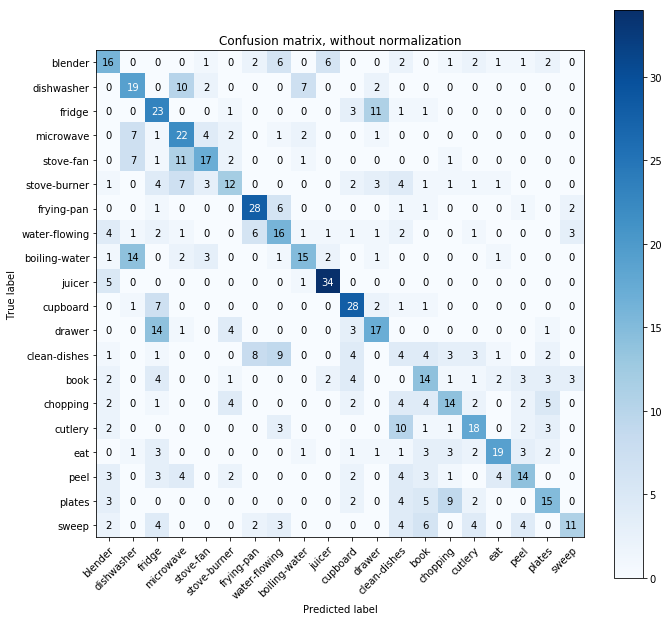

100%|██████████| 200/200 [00:34<00:00,  6.02it/s, best loss: -0.33875]           
best:  {'C': 4.513431053405937, 'gamma': 0.0014884609123128347}
{'random_state': 1000, 'C': 4.513431053405937, 'gamma': 0.0014884609123128347, 'kernel': 'rbf'} -- acc:  0.33875


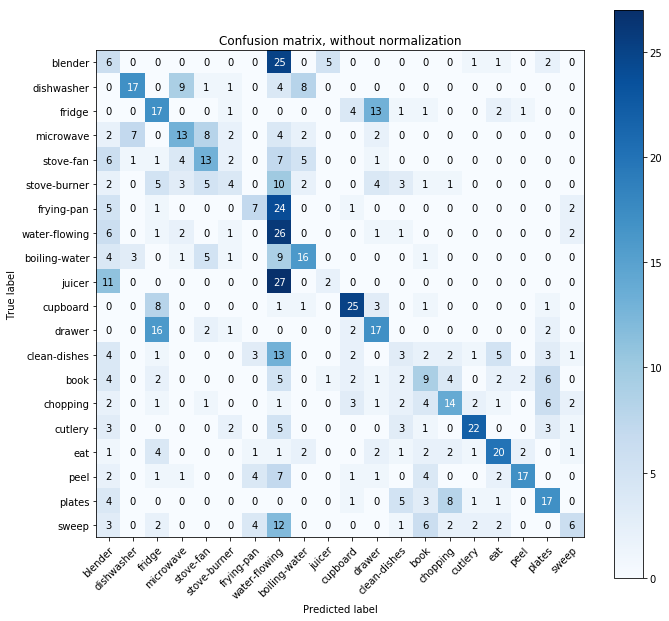

100%|██████████| 200/200 [00:32<00:00,  6.05it/s, best loss: -0.37875000000000003]
best:  {'C': 2.031391549498748, 'gamma': 10.350731537459911}
{'random_state': 1000, 'C': 2.031391549498748, 'gamma': 10.350731537459911, 'kernel': 'poly'} -- acc:  0.37875000000000003


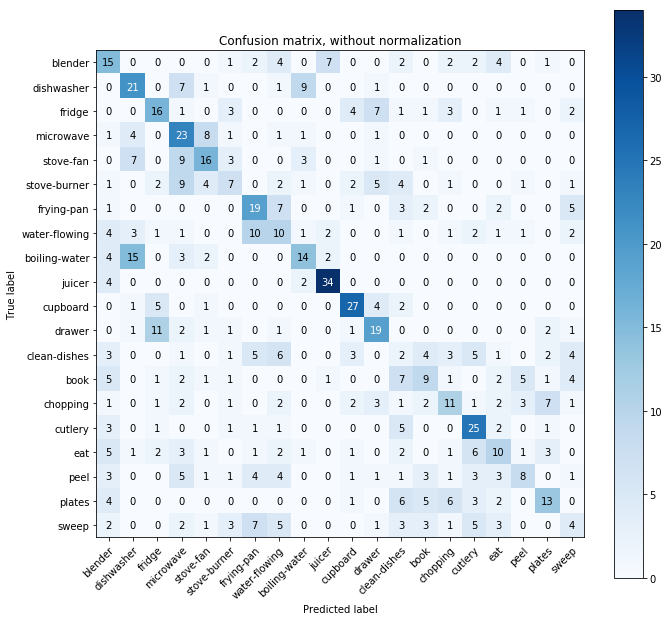

In [4]:
import sklearn as sk
import sklearn.ensemble
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt
from sklearn.model_selection import cross_val_score


fStart = 'MFCC_1 mean'
fEnd = 'ZCR std'


def evaluate_algo(params, compute_conf_mat=False):
    # Select the classifier type
    algo = params['type']
    del params['type']
    if algo == 'knn':
        clf = sk.neighbors.KNeighborsClassifier(**params)
    elif algo == 'svm':
        clf = sk.svm.SVC(**params)
    elif algo == 'randomforest':
        clf = sk.ensemble.RandomForestClassifier(**params)
    
    # Apply classifier on all folds
    accs = 0
    all_conf_mat = np.zeros((20, 20), dtype=int)
    for fold in range(1, 6):
        # Train/Test data
        train = df[df['fold'] != fold].copy()
        test = df[df['fold'] == fold].copy()
        
        # Fit classifier and retrieve test accuracy
        clf.fit(train.loc[:, fStart:fEnd], train['category'])
        test.loc[:, 'prediction'] = clf.predict(test.loc[:, fStart:fEnd])
        accs += np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        
        # Maybe compute confusion matrix
        if compute_conf_mat:
            conf_mat = sk.metrics.confusion_matrix(test['category'], test['prediction'])
            all_conf_mat = all_conf_mat + conf_mat
            
    # After 6 folds, return desired values
    if compute_conf_mat:
        return accs/5., all_conf_mat
    else:
        return accs/5.


def fix_space_dict(new_space, src_space):
    '''Adds missing values in new_space'''
    # Fix array items
    for k, v in src_space.items():
        if type(v) == hyperopt.pyll.base.Apply:
            if v.name == 'int':  # Fix int values
                new_space[k] = int(best[k])
            if v.name == 'switch':  # Fix array values
                idx = new_space[k] + 1
                new_space[k] = v.pos_args[idx].eval()
        if k not in new_space.keys():  # Fix missing values
            best[k] = v


spaces = [
    {
        'type': 'knn',
        'n_neighbors': scope.int(hp.uniform('n_neighbors', 1, 400))},
    {
        'type': 'randomforest',
        'n_estimators': scope.int(hp.uniform('n_estimators', 1, 1000)),
        'max_features': scope.int(hp.uniform('max_features', 1, 10)),
        'max_depth': scope.int(hp.uniform('max_depth', 1, 20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'random_state': 1000},
    {
        'type': 'svm',
        'kernel': 'linear',
        'C': hp.uniform('C', 0, 10.0),
        'gamma': hp.uniform('gamma', 0, 20.0),
        'random_state': 1000},
    {
        'type': 'svm',
        'kernel': 'rbf',
        'C': hp.uniform('C', 0, 10.0),
        'gamma': hp.uniform('gamma', 0, 20.0),
        'random_state': 1000},
    {
        'type': 'svm',
        'kernel': 'poly',
        'C': hp.uniform('C', 0, 10.0),
        'gamma': hp.uniform('gamma', 0, 20.0),
        'random_state': 1000},
]


def f(params):
    acc = evaluate_algo(params)
    return {'loss': -acc, 'status': STATUS_OK}


for space in spaces:
    trials = Trials()
    best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials)
    print('best: ', best)
    
    # Correct the best run dictionary
    best['type'] = space['type']
    fix_space_dict(best, space)
    
    # Compute best parameter's confusion matrix
    accs, conf_mat = evaluate_algo(best, True)
    print(best, '-- acc: ', accs)
    plot_confusion_matrix(conf_mat, dataset.classes)
    plt.show()

## Find best parameters by hand

In [5]:
import sklearn as sk
import sklearn.ensemble

df_results = pd.DataFrame(columns=['f1','f2','f3','f4','f5'])
features_start = 'MFCC_1 mean'
features_end = 'ZCR std'
confusion = {}


def train_on(algo_name, train, test):
    # Choose classifier
    if algo_name.startswith('knn'):
        n_neighbors = int(algo_name.split('_')[1])
        classifier = sk.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif algo_name.startswith('RandomForest'):
        n_estimators = int(algo_name.split('_')[1])
        classifier = sk.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    
    elif algo_name.startswith('SVM'):
        c = float(algo_name.split('_')[1])
        kernel = algo_name.split('_')[2]
        classifier = sk.svm.SVC(C=c, kernel=kernel)
    
    else:
        print('Wrong algorithm name: ', algo_name)

    classifier.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = classifier.predict(test.loc[:, features_start:features_end])
    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    confusion_mat = sk.metrics.confusion_matrix(test['category'], test['prediction'])

    return accuracy, confusion_mat


def record_accuracy(accuracy, df):
    df.loc[algo_name, fold_name] = accuracy

    
def record_conf_mat(confusion_matrix, all_confusions):
    if algo_name not in all_confusions.keys():
        all_confusions[algo_name] = np.zeros((20, 20), dtype=int)
    all_confusions[algo_name] = all_confusions[algo_name] + confusion_matrix


for fold in range(1, 6):
    print('Training fold', fold)
    fold_name = 'f{}'.format(fold)
    train = df[df['fold'] != fold].copy()
    test = df[df['fold'] == fold].copy()

    for i in range(1,13):
        algo_name = 'knn_{}'.format(i)
        accuracy, confusion_current = train_on(algo_name, train, test)
        record_accuracy(accuracy, df_results)
        record_conf_mat(confusion_current, confusion)
    
    for i in [300, 400, 500, 600, 700]:
        algo_name = 'RandomForest_{}'.format(i)
        accuracy, confusion_current = train_on(algo_name, train, test)
        record_accuracy(accuracy, df_results)
        record_conf_mat(confusion_current, confusion)

    for k in ['linear', 'poly']:
        for i in [0.05, 0.1, 0.2, 0.5, 0.9, 1, 2, 10, 100]:
            algo_name = 'SVM_{}_{}'.format(i, k)
            accuracy, confusion_current = train_on(algo_name, train, test)
            record_accuracy(accuracy, df_results)
            record_conf_mat(confusion_current, confusion)

print('Finished')

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Finished


In [6]:
df_results['average'] = df_results.mean(axis=1)
df_results

,f1,f2,f3,f4,f5,average
knn_1,0.30625,0.3125,0.35,0.375,0.41875,0.35250
knn_2,0.28125,0.25625,0.35,0.375,0.41875,0.33625
knn_3,0.3125,0.2875,0.34375,0.3625,0.43125,0.34750
knn_4,0.3375,0.25625,0.36875,0.375,0.475,0.36250
knn_5,0.30625,0.30625,0.33125,0.36875,0.41875,0.34625
knn_6,0.29375,0.29375,0.325,0.39375,0.4125,0.34375
knn_7,0.3125,0.2875,0.36875,0.35,0.425,0.34875
knn_8,0.29375,0.30625,0.35,0.38125,0.41875,0.35000
knn_9,0.3125,0.29375,0.3625,0.33125,0.4125,0.34250
knn_10,0.2625,0.3,0.35,0.3375,0.40625,0.33125
